<a href="https://colab.research.google.com/github/SandroMuradashvili/CNN/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# NOTEBOOK 1: train.ipynb
# Simpsons Character Classification - Training Pipeline
# ============================================================================

# ============================================================================
# STEP 1: Setup and Install Dependencies
# ============================================================================
!pip install gdown -q


In [ ]:
# ============================================================================
# STEP 2: Set Random Seeds for Reproducibility
# ============================================================================
import random
import numpy as np
import torch
import os

# Set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


In [ ]:
# ============================================================================
# STEP 3: Download and Extract Dataset from Google Drive
# ============================================================================
import gdown
import zipfile
import os

# Download the zip file using the direct file ID
file_id = "1uQIS6YAwCpOZ71npdeShM589GK9J_vYh"
zip_file = "simpsons_data.zip"

print("Downloading dataset from Google Drive...")
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_file, quiet=False)
print("✓ Download complete")

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')
print("✓ Extraction complete")

# ============================================================================
# STEP 4: Locate Training Data Directory
# ============================================================================
print("\nLocating training directory...")

# Find characters_train directory
train_dir = None
for root, dirs, files in os.walk('.'):
    if 'characters_train' in dirs:
        train_dir = os.path.join(root, 'characters_train')
        break

if train_dir is None:
    raise FileNotFoundError("Could not find characters_train directory!")

print(f"✓ Training directory found: {train_dir}")

Downloading...
From (original): https://drive.google.com/uc?id=1uQIS6YAwCpOZ71npdeShM589GK9J_vYh
From (redirected): https://drive.google.com/uc?id=1uQIS6YAwCpOZ71npdeShM589GK9J_vYh&confirm=t&uuid=88f17312-5974-4642-81f7-09fa30a3977a
To: /content/simpsons_data.zip
100%|██████████| 424M/424M [00:06<00:00, 63.1MB/s]


✓ Download complete
Extracting dataset...
✓ Extraction complete

Locating training directory...
✓ Training directory found: ./Simpsons/characters_train


In [ ]:
# ============================================================================
# STEP 5: Explore Dataset Structure
# ============================================================================
from collections import Counter

# Get all class directories (filter out .DS_Store and other non-directories)
class_dirs = [d for d in os.listdir(train_dir)
              if os.path.isdir(os.path.join(train_dir, d)) and not d.startswith('.')]
class_dirs.sort()

print(f"\n📊 Dataset Statistics:")
print(f"   Number of classes: {len(class_dirs)}")
print(f"   Classes: {class_dirs[:5]}... (showing first 5)")

# Count images per class
class_counts = {}
for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    # Filter out .DS_Store and other hidden files
    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]
    class_counts[class_name] = len(images)

total_images = sum(class_counts.values())
print(f"   Total training images: {total_images}")
print(f"   Images per class (min/max): {min(class_counts.values())}/{max(class_counts.values())}")


📊 Dataset Statistics:
   Number of classes: 42
   Classes: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson']... (showing first 5)
   Total training images: 16764
   Images per class (min/max): 3/1797


In [ ]:
# ============================================================================
# STEP 6: Import Required Libraries
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

print("✓ Libraries imported")

✓ Libraries imported


In [ ]:
# ============================================================================
# STEP 7: Create Custom Dataset Class
# ============================================================================
class SimpsonsDataset(Dataset):
    """Custom Dataset for Simpsons Characters"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # Get all class directories
        class_dirs = [d for d in os.listdir(root_dir)
                     if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')]
        class_dirs.sort()
        self.class_names = class_dirs
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}

        # Load all image paths and labels
        for class_name in class_dirs:
            class_path = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            # Get all image files (filter out .DS_Store)
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                self.images.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

print("✓ Custom Dataset class created")

✓ Custom Dataset class created


In [ ]:
# ============================================================================
# STEP 8: Define Data Transforms (with Augmentation)
# ============================================================================
IMG_SIZE = 128  # Balanced between speed and accuracy

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Data transforms defined")


✓ Data transforms defined


In [ ]:
# ============================================================================
# STEP 9: Create Dataset and Split into Train/Validation
# ============================================================================
# Create full dataset with validation transforms first (we'll apply train transforms later)
full_dataset = SimpsonsDataset(train_dir, transform=None)

# Split into train and validation (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms to each subset
train_dataset.dataset.transform = train_transform
# For validation, we need to create a new dataset object with val_transform
val_dataset_transformed = SimpsonsDataset(train_dir, transform=val_transform)
# Copy the indices from the split
val_indices = val_dataset.indices
val_dataset = torch.utils.data.Subset(val_dataset_transformed, val_indices)

print(f"✓ Dataset split: {train_size} training, {val_size} validation")

✓ Dataset split: 13411 training, 3353 validation


In [ ]:
# ============================================================================
# STEP 10: Create Data Loaders
# ============================================================================
BATCH_SIZE = 32  # Balanced for speed and GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ DataLoaders created (batch size: {BATCH_SIZE})")

✓ DataLoaders created (batch size: 32)


In [ ]:
# ============================================================================
# STEP 11: Define CNN Architecture
# ============================================================================
class SimpleCNN(nn.Module):
    """Custom CNN for Simpsons Character Classification"""

    def __init__(self, num_classes=41):
        super(SimpleCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Initialize model
num_classes = len(full_dataset.class_names)
model = SimpleCNN(num_classes=num_classes)

print(f"✓ CNN model created with {num_classes} output classes")

✓ CNN model created with 42 output classes


In [ ]:
# ============================================================================
# STEP 12: Setup Training Configuration
# ============================================================================
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("✓ Training configuration set")

✓ Using device: cuda
✓ Training configuration set


In [12]:
# ============================================================================
# STEP 13: Training Loop
# ============================================================================
NUM_EPOCHS = 25  # Balanced for time and performance

print(f"\n🚀 Starting training for {NUM_EPOCHS} epochs...\n")

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': full_dataset.class_names,
            'class_to_idx': full_dataset.class_to_idx
        }, 'simpson_model_best.pth')

print(f"✓ Training completed! Best validation accuracy: {best_val_acc:.2f}%")


🚀 Starting training for 25 epochs...

Epoch [1/25]
  Train Loss: 3.2996 | Train Acc: 12.65%
  Val Loss: 2.7375 | Val Acc: 20.73%

Epoch [2/25]
  Train Loss: 2.8078 | Train Acc: 20.43%
  Val Loss: 2.3192 | Val Acc: 34.48%

Epoch [3/25]
  Train Loss: 2.6330 | Train Acc: 25.37%
  Val Loss: 2.1076 | Val Acc: 37.46%

Epoch [4/25]
  Train Loss: 2.4359 | Train Acc: 30.49%
  Val Loss: 1.9356 | Val Acc: 43.48%

Epoch [5/25]
  Train Loss: 2.2916 | Train Acc: 33.34%
  Val Loss: 1.9203 | Val Acc: 46.44%

Epoch [6/25]
  Train Loss: 2.1364 | Train Acc: 37.16%
  Val Loss: 1.6173 | Val Acc: 51.39%

Epoch [7/25]
  Train Loss: 1.9830 | Train Acc: 41.34%
  Val Loss: 1.3683 | Val Acc: 59.62%

Epoch [8/25]
  Train Loss: 1.8441 | Train Acc: 44.96%
  Val Loss: 1.3768 | Val Acc: 62.12%

Epoch [9/25]
  Train Loss: 1.7260 | Train Acc: 48.22%
  Val Loss: 1.2352 | Val Acc: 63.14%

Epoch [10/25]
  Train Loss: 1.6273 | Train Acc: 50.48%
  Val Loss: 1.1045 | Val Acc: 69.43%

Epoch [11/25]
  Train Loss: 1.5480 | Tra

In [13]:
# ============================================================================
# STEP 14: Save Final Model
# ============================================================================
# Save the final model state
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': full_dataset.class_names,
    'class_to_idx': full_dataset.class_to_idx,
    'num_classes': num_classes
}, 'simpson_model.pth')

print("✓ Final model saved as 'simpson_model.pth'")
print("✓ Best model saved as 'simpson_model_best.pth'")

✓ Final model saved as 'simpson_model.pth'
✓ Best model saved as 'simpson_model_best.pth'


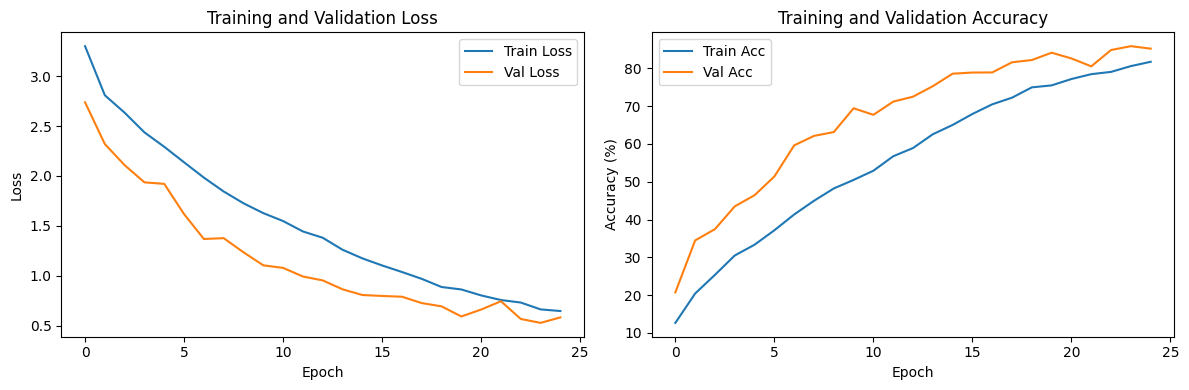


✅ TRAINING PIPELINE COMPLETE!
   Final model: simpson_model.pth
   Best model: simpson_model_best.pth (Val Acc: 85.86%)
   Training plot: training_history.png


In [14]:
# ============================================================================
# STEP 15: Plot Training History
# ============================================================================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n✅ TRAINING PIPELINE COMPLETE!")
print(f"   Final model: simpson_model.pth")
print(f"   Best model: simpson_model_best.pth (Val Acc: {best_val_acc:.2f}%)")
print(f"   Training plot: training_history.png")